# Obesity Rate Correlation Analysis

* The analysis will encompass data from the states of California, Ohio, and South Carolina.
* The objective is to find if there is correlation between obesity rate and the following measurements: 
    * Median household income
    * % With access to exercise opportunities
    * % of physically inactive
    * Primary care physicians rate
    * High School Unemployment rate
    * Unemployed rate
    

In [1]:
import requests
import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy.stats import linregress
from pprint import pprint
from api_key import g_key 
import json
import gmaps
import glob
from pprint import pprint
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import linear_model
from scipy import stats
from sklearn.linear_model import LinearRegression
import sklearn.linear_model
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Countyhealthrankings data for California, Ohio and South Carolina
# source https://www.countyhealthrankings.org/

path = "./CountyHealthRankings"
all_files = glob.glob(path + "/*.csv")

# Read all csv files in folder and append to create one dataframe

all_states = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    all_states.append(df)
frame = pd.concat(all_states, axis=0, ignore_index=True)
frame.head()
states_health_df = frame[[
                          "FIPS",
                          "% Adults with Obesity",
                          "% Physically Inactive",
                          "% With Access to Exercise Opportunities",
                          "Primary Care Physicians Rate",
                          "High School Graduation Rate",
                          "% Unemployed"
                        ]]
states_health_df.head()

,FIPS,% Adults with Obesity,% Physically Inactive,% With Access to Exercise Opportunities,Primary Care Physicians Rate,High School Graduation Rate,% Unemployed
0,33000,28,21,88.0,91.0,89.0,2.5
1,33001,29,23,87.0,64.0,88.0,2.5
2,33003,27,22,81.0,92.0,94.0,2.5
3,33005,30,19,75.0,68.0,89.0,2.5
4,33007,34,26,74.0,114.0,92.0,3.2


In [3]:
# Census URL to collect median household income for 2018 for every state and county

url = "https://api.census.gov/data/2018/acs/acs5?get=NAME,B19013_001E&for=county:*&in=state:*"
print(url)

https://api.census.gov/data/2018/acs/acs5?get=NAME,B19013_001E&for=county:*&in=state:*


## Data Cleaning
* Cleaning Data from the US Census and countyhealthrankings for the following states:
    * California 
    * Texas
    * Florida

In [4]:
# Converting census request into a DataFrame

census_data = requests.get(url).json()
census_df = pd.DataFrame(census_data).drop([0,])
census_df.head()

,0,1,2,3
1,"Washington County, Mississippi",30834,28,151
2,"Perry County, Mississippi",39007,28,111
3,"Choctaw County, Mississippi",37203,28,019
4,"Itawamba County, Mississippi",40510,28,057
5,"Carroll County, Mississippi",43060,28,015


In [5]:
# Renaming column headers from US Census data

rename_census_df = census_df.rename(columns = {0:"County and State",
                             1:"Median Income",
                             2:"State Code",
                             3: "County Code"})
rename_census_df.head()

,County and State,Median Income,State Code,County Code
1,"Washington County, Mississippi",30834,28,151
2,"Perry County, Mississippi",39007,28,111
3,"Choctaw County, Mississippi",37203,28,019
4,"Itawamba County, Mississippi",40510,28,057
5,"Carroll County, Mississippi",43060,28,015


In [6]:
# Combining State and County Code in order to merge the DataFrame with the Countyhealthrankings
# DataFrame

rename_census_df["FIPS"] = rename_census_df["State Code"].astype(str) + rename_census_df["County Code"].astype(str)
rename_census_df.head()

,County and State,Median Income,State Code,County Code,FIPS
1,"Washington County, Mississippi",30834,28,151,28151
2,"Perry County, Mississippi",39007,28,111,28111
3,"Choctaw County, Mississippi",37203,28,019,28019
4,"Itawamba County, Mississippi",40510,28,057,28057
5,"Carroll County, Mississippi",43060,28,015,28015


In [7]:
# Splitting the County and State column and creating two new columns for "County" and "State"
# to filter by California, Ohio and South Carolina

county_state = rename_census_df["County and State"].str.split(",", n = 0, expand = True) 
rename_census_df["County"]= county_state[0]
rename_census_df["State"] = county_state[1]
rename_census_df.head()

,County and State,Median Income,State Code,County Code,FIPS,County,State
1,"Washington County, Mississippi",30834,28,151,28151,Washington County,Mississippi
2,"Perry County, Mississippi",39007,28,111,28111,Perry County,Mississippi
3,"Choctaw County, Mississippi",37203,28,019,28019,Choctaw County,Mississippi
4,"Itawamba County, Mississippi",40510,28,057,28057,Itawamba County,Mississippi
5,"Carroll County, Mississippi",43060,28,015,28015,Carroll County,Mississippi


In [8]:
# Create a copy of the states_df to format FIPS column

states_health_df_copy = states_health_df.copy()
reformat_fips = states_health_df_copy['FIPS'].apply('{:0>5}'.format)
fips_df = pd.DataFrame(reformat_fips)
states_health_df_copy["FIPS"] = fips_df
states_health_df_copy.head()


,FIPS,% Adults with Obesity,% Physically Inactive,% With Access to Exercise Opportunities,Primary Care Physicians Rate,High School Graduation Rate,% Unemployed
0,33000,28,21,88.0,91.0,89.0,2.5
1,33001,29,23,87.0,64.0,88.0,2.5
2,33003,27,22,81.0,92.0,94.0,2.5
3,33005,30,19,75.0,68.0,89.0,2.5
4,33007,34,26,74.0,114.0,92.0,3.2


In [9]:
# Merge US Census data frame 'states_health_df_copy' with County Health Rankings Data 'indiciators_data' 

indicators_data = rename_census_df[["County and State","Median Income","FIPS","State","County"]].sort_values(by=['FIPS'])
all_states_merge = pd.merge(states_health_df_copy,indicators_data,on="FIPS",how="left")
all_states_merge.head()

,FIPS,% Adults with Obesity,% Physically Inactive,% With Access to Exercise Opportunities,Primary Care Physicians Rate,High School Graduation Rate,% Unemployed,County and State,Median Income,State,County
0,33000,28,21,88.0,91.0,89.0,2.5,NaN,NaN,NaN,NaN
1,33001,29,23,87.0,64.0,88.0,2.5,"Belknap County, New Hampshire",68368,New Hampshire,Belknap County
2,33003,27,22,81.0,92.0,94.0,2.5,"Carroll County, New Hampshire",61116,New Hampshire,Carroll County
3,33005,30,19,75.0,68.0,89.0,2.5,"Cheshire County, New Hampshire",63057,New Hampshire,Cheshire County
4,33007,34,26,74.0,114.0,92.0,3.2,"Coos County, New Hampshire",45696,New Hampshire,Coos County


In [10]:
# Export dataframe to CSV

clean_all_states = all_states_merge.dropna()
clean_all_states.to_csv('./final_dataframe.csv', index=False)

# Correlation and Regression Analysis

### Florida - Obesity Rate vs. % Physically Inactive

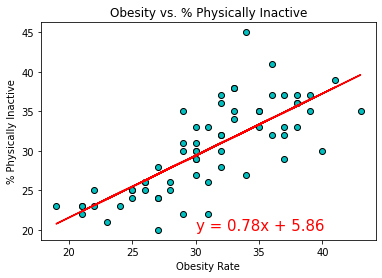

The r-squared value is: 0.7628220794645032


In [54]:
fl_analysis = clean_all_states.loc[clean_all_states["State"] == " Florida" ]
fl_obesity_rate = fl_analysis["% Adults with Obesity"]
fl_physical = fl_analysis["% Physically Inactive"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(fl_obesity_rate, fl_physical)
regress_values = fl_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(fl_obesity_rate,fl_physical,color="c",edgecolors="black")
plt.plot(fl_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(30,20),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("% Physically Inactive")
plt.title("Obesity vs. % Physically Inactive")
plt.savefig("output_diagrams/florida_obesity_physical_activity.png")
plt.show()

(print(f"The r-squared value is: {rvalue}"))

### Florida - Obesity Rate vs. % With Access to Exercise Opportunities

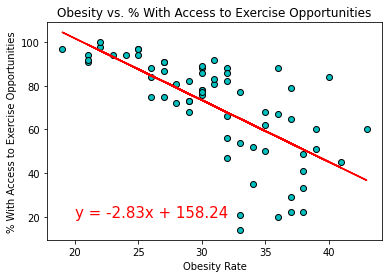

The r-squared value is: -0.6827460730267716


In [65]:
fl_exercise = fl_analysis["% With Access to Exercise Opportunities"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(fl_obesity_rate, fl_exercise)
regress_values = fl_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(fl_obesity_rate,fl_exercise,color="c",edgecolors="black")
plt.plot(fl_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(20,20),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("% With Access to Exercise Opportunities")
plt.title("Obesity vs. % With Access to Exercise Opportunities")
plt.savefig("output_diagrams/florida_obesity_exercise_opportunities.png")
plt.show()

(print(f"The r-squared value is: {rvalue}"))

### Florida - Obesity Rate vs. Primary Care Physicians Rate

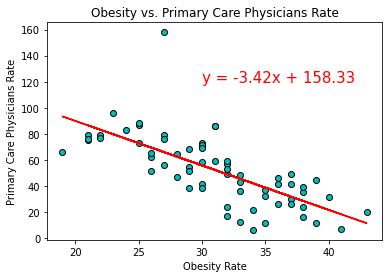

The r-squared value is: -0.7060608869434568


In [76]:
fl_physician = fl_analysis["Primary Care Physicians Rate"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(fl_obesity_rate, fl_physician)
regress_values = fl_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(fl_obesity_rate,fl_physician,color="c",edgecolors="black")
plt.plot(fl_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(30,120),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("Primary Care Physicians Rate")
plt.title("Obesity vs. Primary Care Physicians Rate")
plt.savefig("output_diagrams/florida_obesity_primary_care.png")
plt.show()

(print(f"The r-squared value is: {rvalue}"))

### Florida - Obesity Rate vs. High School Graduation Rate

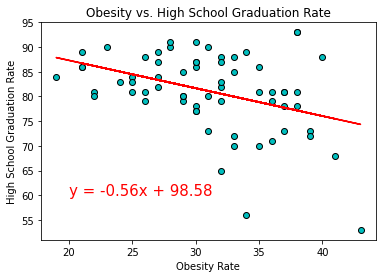

The r-squared value is: -0.39257277154130893


In [55]:
fl_graduation = fl_analysis["High School Graduation Rate"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(fl_obesity_rate, fl_graduation)
regress_values = fl_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(fl_obesity_rate,fl_graduation,color="c",edgecolors="black")
plt.plot(fl_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(20,60),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("High School Graduation Rate")
plt.title("Obesity vs. High School Graduation Rate")
plt.savefig("output_diagrams/florida_obesity_hs_graduation.png")
plt.show()

(print(f"The r-squared value is: {rvalue}"))

### Florida - Obesity Rate vs. % Unemployed

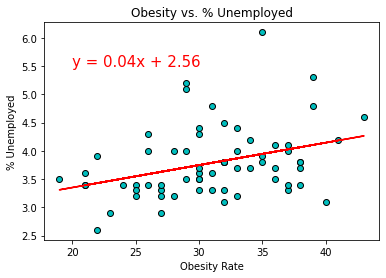

The r-squared value is: 0.35124253540383915


In [56]:
fl_unemployed = fl_analysis["% Unemployed"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(fl_obesity_rate, fl_unemployed)
regress_values = fl_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(fl_obesity_rate,fl_unemployed,color="c",edgecolors="black")
plt.plot(fl_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(20,5.5),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("% Unemployed")
plt.title("Obesity vs. % Unemployed")
plt.savefig("output_diagrams/florida_obesity_unemployed.png")
plt.show()

(print(f"The r-squared value is: {rvalue}"))

### Florida - Obesity Rate vs. Median Household Income

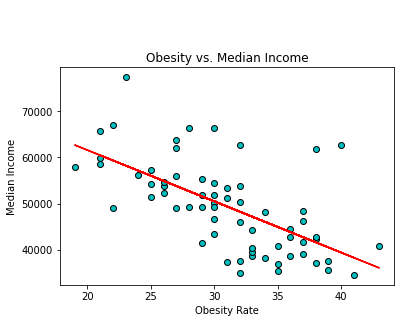

The r-squared value is: -0.6267710288163144


In [57]:
fl_median_income = fl_analysis["Median Income"].astype(int)

(slope, intercept, rvalue, pvalue, stderr) = linregress(fl_obesity_rate, fl_median_income)
regress_values = fl_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(fl_obesity_rate,fl_median_income,color="c",edgecolors="black")
plt.plot(fl_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(26,90000),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("Median Income")
plt.title("Obesity vs. Median Income")
plt.savefig("output_diagrams/florida_obesity_median_income.png")
plt.show()

(print(f"The r-squared value is: {rvalue}"))

### Texas - Obesity Rate vs. % Physically Inactive

In [15]:
texas_df = clean_all_states.loc[clean_all_states["State"] == " Texas" ]

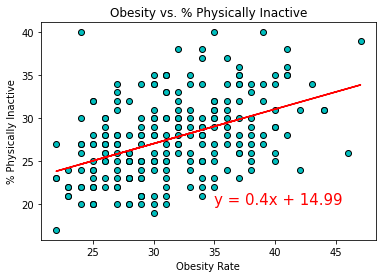

The r-squared value is: 0.4492396454422658


In [58]:
texas_obesity_rate = texas_df["% Adults with Obesity"]
texas_physical = texas_df["% Physically Inactive"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(texas_obesity_rate, texas_physical)
regress_values = texas_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(texas_obesity_rate,texas_physical,color="c",edgecolors="black")
plt.plot(texas_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(35,20),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("% Physically Inactive")
plt.title("Obesity vs. % Physically Inactive")
plt.savefig("output_diagrams/texas_obesity_physical_activity.png")
plt.show()

(print(f"The r-squared value is: {rvalue}"))

### Texas - Obesity Rate vs. % With Access to Exercise Opportunities

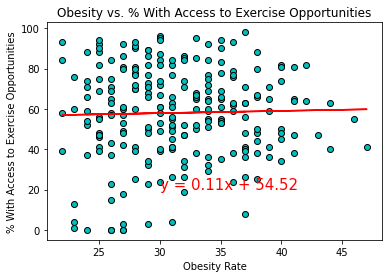

The r-squared value is: 0.026004282262443435


In [59]:
texas_exercise = texas_df["% With Access to Exercise Opportunities"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(texas_obesity_rate, texas_exercise)
regress_values = texas_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(texas_obesity_rate,texas_exercise,color="c",edgecolors="black")
plt.plot(texas_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(30,20),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("% With Access to Exercise Opportunities")
plt.title("Obesity vs. % With Access to Exercise Opportunities")
plt.savefig("output_diagrams/texas_obesity_exercise_opportunities.png")
plt.show()

(print(f"The r-squared value is: {rvalue}"))

### Texas - Obesity Rate vs. Primary Care Physicians Rate

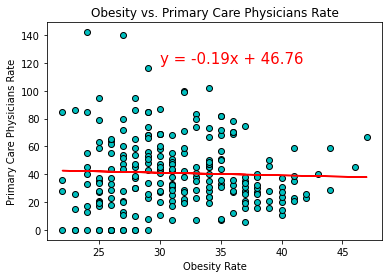

The r-squared value is: -0.038814626067330125


In [66]:
texas_physician = texas_df["Primary Care Physicians Rate"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(texas_obesity_rate, texas_physician)
regress_values = texas_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(texas_obesity_rate,texas_physician,color="c",edgecolors="black")
plt.plot(texas_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(30,120),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("Primary Care Physicians Rate")
plt.title("Obesity vs. Primary Care Physicians Rate")
plt.savefig("output_diagrams/texas_obesity_primary_care.png")
plt.show()

(print(f"The r-squared value is: {rvalue}"))

### Texas - Obesity Rate vs. High School Graduation Rate

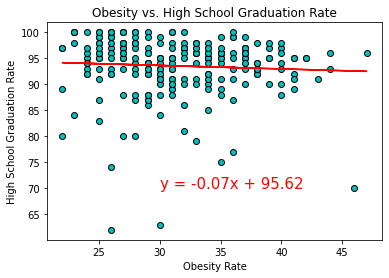

The r-squared value is: -0.061271310454999346


In [67]:
texas_education = texas_df["High School Graduation Rate"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(texas_obesity_rate, texas_education)
regress_values = texas_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(texas_obesity_rate,texas_education,color="c",edgecolors="black")
plt.plot(texas_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(30,70),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("High School Graduation Rate")
plt.title("Obesity vs. High School Graduation Rate")
plt.savefig("output_diagrams/texas_obesity_hs_graduation.png")
plt.show()

(print(f"The r-squared value is: {rvalue}"))

### Texas - Obesity Rate vs. % Unemployed

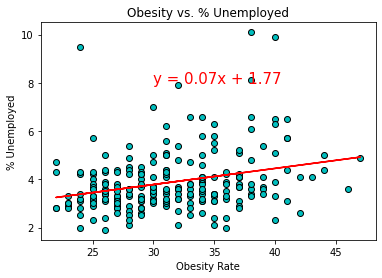

The r-squared value is: 0.28119749582234616


In [68]:
texas_unemployed = texas_df["% Unemployed"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(texas_obesity_rate, texas_unemployed)
regress_values = texas_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(texas_obesity_rate,texas_unemployed,color="c",edgecolors="black")
plt.plot(texas_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(30,8),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("% Unemployed")
plt.title("Obesity vs. % Unemployed")
plt.savefig("output_diagrams/texas_obesity_unemployed.png")
plt.show()

(print(f"The r-squared value is: {rvalue}"))

### Texas - Obesity Rate vs. Median Income

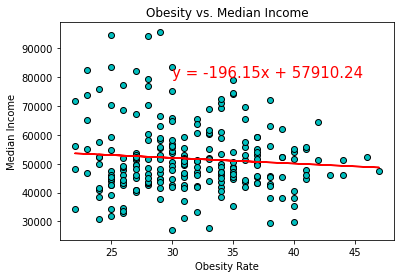

The r-squared value is: -0.0858233192832307


In [69]:
texas_median_income = texas_df["Median Income"].astype(int)

(slope, intercept, rvalue, pvalue, stderr) = linregress(texas_obesity_rate, texas_median_income)
regress_values = texas_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(texas_obesity_rate,texas_median_income,color="c",edgecolors="black")
plt.plot(texas_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(30,80000),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("Median Income")
plt.title("Obesity vs. Median Income")
plt.savefig("output_diagrams/texas_obesity_median_income.png")
plt.show()

(print(f"The r-squared value is: {rvalue}"))

### California - Obesity Rate vs. % Physically Inactive

In [22]:
california_df = clean_all_states.loc[clean_all_states["State"] == " California" ].dropna()

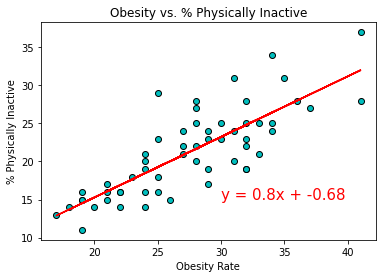

The r-squared value is: 0.800005240411173


In [70]:
california_obesity_rate = california_df["% Adults with Obesity"]
california_physical = california_df["% Physically Inactive"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(california_obesity_rate, california_physical)
regress_values = california_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(california_obesity_rate,california_physical,color="c",edgecolors="black")
plt.plot(california_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(30,15),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("% Physically Inactive")
plt.title("Obesity vs. % Physically Inactive")
plt.savefig("output_diagrams/california_obesity_physical_activity.png")
plt.show()

(print(f"The r-squared value is: {rvalue}"))

### California - Obesity Rate vs. % With Access to Exercise Opportunities

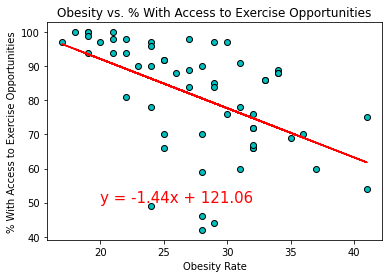

The r-squared value is: -0.5129692276214599


In [71]:
california_exercise = california_df["% With Access to Exercise Opportunities"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(california_obesity_rate, california_exercise)
regress_values = california_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(california_obesity_rate,california_exercise,color="c",edgecolors="black")
plt.plot(california_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(20,50),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("% With Access to Exercise Opportunities")
plt.title("Obesity vs. % With Access to Exercise Opportunities")
plt.savefig("output_diagrams/california_obesity_exercise.png")
plt.show()

(print(f"The r-squared value is: {rvalue}"))

### California - Obesity Rate vs. % Primary Care Physicians Rate

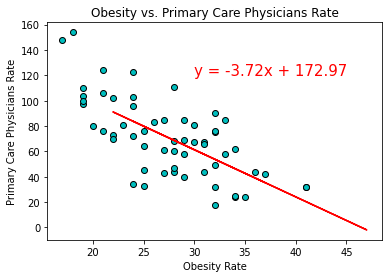

The r-squared value is: -0.6885447168207459


In [72]:
california_physician = california_df["Primary Care Physicians Rate"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(california_obesity_rate, california_physician)
regress_values = texas_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(california_obesity_rate,california_physician,color="c",edgecolors="black")
plt.plot(texas_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(30,120),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("Primary Care Physicians Rate")
plt.title("Obesity vs. Primary Care Physicians Rate")
plt.savefig("output_diagrams/california_obesity_primary_care.png")
plt.show()

(print(f"The r-squared value is: {rvalue}"))

### California - Obesity Rate vs. % High School Graduation

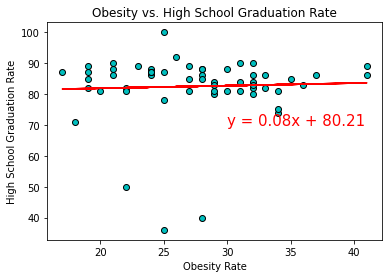

The r-squared value is: 0.044062706452217854


In [73]:
california_education = california_df["High School Graduation Rate"].dropna()

(slope, intercept, rvalue, pvalue, stderr) = linregress(california_obesity_rate, california_education)
regress_values = california_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(california_obesity_rate,california_education,color="c",edgecolors="black")
plt.plot(california_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(30,70),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("High School Graduation Rate")
plt.title("Obesity vs. High School Graduation Rate")
plt.savefig("output_diagrams/california_obesity_hs_graduation.png")
plt.show()

(print(f"The r-squared value is: {rvalue}"))

### California - Obesity Rate vs. % Unemployed

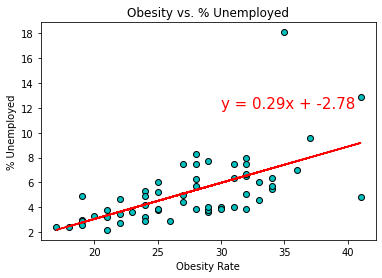

The r-squared value is: 0.6228089181233846


In [74]:
california_unemployed = california_df["% Unemployed"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(california_obesity_rate, california_unemployed)
regress_values = california_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(california_obesity_rate,california_unemployed,color="c",edgecolors="black")
plt.plot(california_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(30,12),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("% Unemployed")
plt.title("Obesity vs. % Unemployed")
plt.savefig("output_diagrams/california_obesity_unemployed.png")
plt.show()

(print(f"The r-squared value is: {rvalue}"))

### California - Obesity Rate vs. Median Income

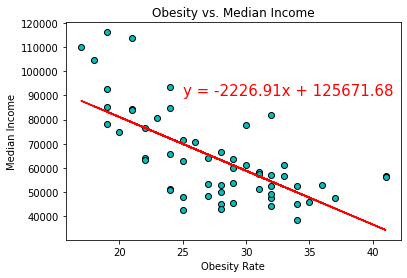

The r-squared value is: -0.6711330059279156


In [75]:
california_median_income = california_df["Median Income"].astype(int)

(slope, intercept, rvalue, pvalue, stderr) = linregress(california_obesity_rate, california_median_income)
regress_values = california_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(california_obesity_rate,california_median_income,color="c",edgecolors="black")
plt.plot(california_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(25,90000),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("Median Income")
plt.title("Obesity vs. Median Income")
plt.savefig("output_diagrams/california_obesity_median_income.png")
plt.show()

(print(f"The r-squared value is: {rvalue}"))

### Top 100 Counties with Highest Obesity Rate Analysis

### Heatmap for Obesity Rate

In [29]:
# Geocodes collected from Socrata
geocode = pd.read_csv("./Geocodes_USA_with_Counties.csv")

# Creating a dataframe for the geocodes
lat_lng = pd.DataFrame(geocode)

In [30]:
# Selecting only needed columns from the lat_lng dataframe 'state','latitude','longitude','county'
all_states_lat_lng = lat_lng.iloc[:,[2,3,4,5]]

# Renameing 'county' to 'County' in order to merge the dataframe with another dataframe
rename_lat_lng = all_states_lat_lng.rename(columns = {"county":"County"})
rename_lat_lng.head()

,state,latitude,longitude,County
0,NY,40.81,-73.04,Suffolk
1,NY,40.81,-73.04,Suffolk
2,PR,18.16,-66.72,Adjuntas
3,PR,18.38,-67.18,NaN
4,PR,18.43,-67.15,Aguadilla


In [31]:
# Removing the word county from the County Health Rankings dataframe 'all_states_merge' in order to merge with geocodes from Socrata

county_series = all_states_merge["County"]
strip_county = county_series.str.rstrip('County')
county_name = strip_county.str.rstrip(' ')
county_name.head()

0         NaN
1     Belknap
2     Carroll
3    Cheshire
4        Coos
Name: County, dtype: object

In [32]:
# Creating a copy of the dataframe in order to replace the "County" column with only the name of the County
clean_all_states_copy = clean_all_states.copy()
clean_all_states_copy["County"] = county_name
clean_all_states_copy.head()

,FIPS,% Adults with Obesity,% Physically Inactive,% With Access to Exercise Opportunities,Primary Care Physicians Rate,High School Graduation Rate,% Unemployed,County and State,Median Income,State,County
1,33001,29,23,87.0,64.0,88.0,2.5,"Belknap County, New Hampshire",68368,New Hampshire,Belknap
2,33003,27,22,81.0,92.0,94.0,2.5,"Carroll County, New Hampshire",61116,New Hampshire,Carroll
3,33005,30,19,75.0,68.0,89.0,2.5,"Cheshire County, New Hampshire",63057,New Hampshire,Cheshire
4,33007,34,26,74.0,114.0,92.0,3.2,"Coos County, New Hampshire",45696,New Hampshire,Coos
5,33009,24,19,90.0,197.0,95.0,2.1,"Grafton County, New Hampshire",63153,New Hampshire,Grafton


In [33]:
# Merging all data from the US Census, County Health Rankings and Socrata

data_merge = pd.merge(clean_all_states_copy,rename_lat_lng,on="County",how="left")
data_merge.head(3)

,FIPS,% Adults with Obesity,% Physically Inactive,% With Access to Exercise Opportunities,Primary Care Physicians Rate,High School Graduation Rate,% Unemployed,County and State,Median Income,State,County,state,latitude,longitude
0,33001,29,23,87.0,64.0,88.0,2.5,"Belknap County, New Hampshire",68368,New Hampshire,Belknap,NH,43.33,-71.29
1,33001,29,23,87.0,64.0,88.0,2.5,"Belknap County, New Hampshire",68368,New Hampshire,Belknap,NH,43.44,-71.47
2,33001,29,23,87.0,64.0,88.0,2.5,"Belknap County, New Hampshire",68368,New Hampshire,Belknap,NH,43.33,-71.23


In [34]:
# Dropping duplicates from the dataset

clean_dataset = data_merge.dropna()
drop_duplicates = clean_dataset.drop_duplicates(subset="County")
drop_duplicates.head(2)

,FIPS,% Adults with Obesity,% Physically Inactive,% With Access to Exercise Opportunities,Primary Care Physicians Rate,High School Graduation Rate,% Unemployed,County and State,Median Income,State,County,state,latitude,longitude
0,33001,29,23,87.0,64.0,88.0,2.5,"Belknap County, New Hampshire",68368,New Hampshire,Belknap,NH,43.33,-71.29
19,33003,27,22,81.0,92.0,94.0,2.5,"Carroll County, New Hampshire",61116,New Hampshire,Carroll,NH,43.83,-71.47


In [35]:
figure = gmaps.figure()


lat_lng = drop_duplicates[["latitude","longitude"]]
obesity = drop_duplicates["% Adults with Obesity"]

# Create heat layer
heat_layer = gmaps.heatmap_layer(lat_lng, weights=obesity, 
                                 dissipating=False, max_intensity=100,
                                 point_radius=.8)


# Add layer
figure.add_layer(heat_layer)

# Display figure
figure

Figure(layout=FigureLayout(height='420px'))

### Top 100 Counties with the highest obesity rate analysis

In [99]:
sort_obesity = clean_all_states.sort_values(by=["% Adults with Obesity"],ascending=False).reset_index()
drop_index = sort_obesity.drop(['index'], axis=1)
top_100_obesity = drop_index[:100]
top_100_series = top_100_obesity["County"]
top_100_strip_county = top_100_series.str.rstrip('County')
top_100_county_name = top_100_strip_county.str.rstrip(' ')
top_100_obesity_copy = top_100_obesity.copy()
top_100_obesity_copy["County"] = top_100_county_name
top_100_obesity_merge = pd.merge(top_100_obesity_copy,rename_lat_lng,on="County",how="left")
clean_100 = top_100_obesity_merge.dropna()
drop_100_duplicates = clean_100.drop_duplicates(subset="County")
drop_100_duplicates.head(2)

,FIPS,% Adults with Obesity,% Physically Inactive,% With Access to Exercise Opportunities,Primary Care Physicians Rate,High School Graduation Rate,% Unemployed,County and State,Median Income,State,County,state,latitude,longitude
0,13301,58,28,8.0,57.0,88.0,5.0,"Warren County, Georgia",34730,Georgia,Warren,NJ,40.91,-74.83
143,28063,54,35,61.0,55.0,88.0,13.3,"Jefferson County, Mississippi",20188,Mississippi,Jefferson,NY,43.97,-75.91


In [100]:
figure = gmaps.figure()


lat_lng_100 = drop_100_duplicates[["latitude","longitude"]]
obesity_100 = drop_100_duplicates["% Adults with Obesity"]

# Create heat layer
heat_layer = gmaps.heatmap_layer(lat_lng_100, weights=obesity_100, 
                                 dissipating=False, max_intensity=100,
                                 point_radius=.8)


# Add layer
figure.add_layer(heat_layer)

# Display figure
figure

Figure(layout=FigureLayout(height='420px'))

In [101]:
top_100_obesity.describe()

,% Adults with Obesity,% Physically Inactive,% With Access to Exercise Opportunities,Primary Care Physicians Rate,High School Graduation Rate,% Unemployed
count,100.00000,100.000000,100.000000,100.00000,100.000000,100.000000
mean,44.94000,33.480000,46.510000,36.41000,86.020000,5.307000
std,2.82421,6.015938,22.472652,19.75358,7.441326,1.796532
min,42.00000,19.000000,2.000000,8.00000,53.000000,2.100000
25%,43.00000,30.000000,31.000000,21.75000,82.000000,4.175000
50%,44.00000,33.000000,48.500000,35.00000,86.000000,5.100000
75%,46.00000,37.250000,64.000000,45.25000,91.000000,5.825000
max,58.00000,50.000000,100.000000,122.00000,99.000000,13.300000


In [103]:
top_100_obesity["State"].value_counts()

 Mississippi       15
 Arkansas          10
 Alabama           10
 Georgia           10
 Louisiana          9
 North Carolina     8
 Texas              6
 Virginia           4
 Wisconsin          3
 Tennessee          3
 Kentucky           3
 South Carolina     3
 West Virginia      2
 Iowa               2
 Oklahoma           2
 Florida            1
 Missouri           1
 Indiana            1
 Alaska             1
 Maryland           1
 Kansas             1
 North Dakota       1
 Oregon             1
 Nebraska           1
 Michigan           1
Name: State, dtype: int64

# Omnibus Models

### The omnibus model tests all the proposed predictors together to see which ones would best be part of a "best fit" model. For the omnibus model, only data from California, Texas, and Florida will be used

### This section considers three models:
1. The Overall model tests all predictors to see how all proposed predictors will work together.

2. The Economic-Demographic model tests only economic predictors (e.g. Median Income) and demographic predictors (e.g. high school graduation rate)

3. The ealth model tests only health policy predictors (e,g. physical inactivity, Access to care)

All three models will be compared to select the predictors for the best fit model

### OVERALL MODEL


In [11]:
csvpath = "./final_dataframe.csv"
omni_df = pd.read_csv(csvpath)
sample_df = omni_df.loc[(omni_df["State"]==" California") | (omni_df["State"]==" Texas") | (omni_df["State"]==" Florida") ]
sample_df.head()
sample_df.to_csv("output_diagrams/modeling_data.csv",index=False)

In [12]:
X = sample_df[['% With Access to Exercise Opportunities', '% Physically Inactive' ,'High School Graduation Rate',  'Median Income', 'Primary Care Physicians Rate', '% Unemployed']].astype(float)
Y = sample_df['% Adults with Obesity'].astype(float)
X.head()

,% With Access to Exercise Opportunities,% Physically Inactive,High School Graduation Rate,Median Income,Primary Care Physicians Rate,% Unemployed
1357,100.0,15.0,87.0,92574.0,110.0,3.0
1358,76.0,25.0,88.0,61198.0,67.0,4.0
1359,84.0,22.0,85.0,48443.0,61.0,5.0
1360,60.0,31.0,90.0,58151.0,44.0,4.0
1361,75.0,28.0,89.0,56704.0,32.0,12.9


In [13]:
regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Intercept: 
 14.145343337709765
Coefficients: 
 [ 7.09110354e-03  5.26867058e-01  5.41385799e-03 -8.44446062e-07
 -2.36631532e-02  6.27483900e-01]


In [14]:
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
predictions.head()

1357    22.687505
1358    29.308174
1359    27.882167
1360    33.269645
1361    39.326733
dtype: float64

In [15]:
print_model = model.summary()
print(print_model)

                                  OLS Regression Results                                  
Dep. Variable:     % Adults with Obesity   R-squared (uncentered):                   0.980
Model:                               OLS   Adj. R-squared (uncentered):              0.980
Method:                    Least Squares   F-statistic:                              2886.
Date:                   Sun, 29 Nov 2020   Prob (F-statistic):                   2.58e-293
Time:                           22:30:32   Log-Likelihood:                         -1025.5
No. Observations:                    354   AIC:                                      2063.
Df Residuals:                        348   BIC:                                      2086.
Df Model:                              6                                                  
Covariance Type:               nonrobust                                                  
                                              coef    std err          t      P>|t|      [

In [16]:
# Overall Model: Analysi f the overall model suggests a multicollinearity problem. This means that at least some of the predictors are intercorrelated and should not be used as predictors in the same model. The Multiple R is .980; which means thataround 98 percent of the variance in obesity rates in the sample data is explained/predicted by variations in the
# 7 predictors in this model. However, the F-ratio is infinitessimally low, which suggests that this model has very low generalizability. 
# The small coefficient for each predictor in the model is likely a product of chance. The overall model is unsuitable for further analysis; but it does suggest unemployment rate and physical inactivity play a bigger role in obesity rates than the other predictors,

## Economic and Demograhic Model
## Model 1: All Economic/ Demographic Predictors

In [17]:
X = sample_df[['High School Graduation Rate',  'Median Income', '% Unemployed']].astype(float)
Y = sample_df['% Adults with Obesity'].astype(float)
X.head()

,High School Graduation Rate,Median Income,% Unemployed
1357,87.0,92574.0,3.0
1358,88.0,61198.0,4.0
1359,85.0,48443.0,5.0
1360,90.0,58151.0,4.0
1361,89.0,56704.0,12.9


In [18]:
regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Intercept: 
 31.780954939908327
Coefficients: 
 [ 3.62534257e-02 -1.24641369e-04  5.78210321e-01]


In [19]:
X = sm.add_constant(X) 
 
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
predictions.head()

1357    25.131084
1358    29.656295
1359    31.715546
1360    30.108584
1361    35.398759
dtype: float64

In [20]:
print_model = model.summary()
print(print_model)

                              OLS Regression Results                             
Dep. Variable:     % Adults with Obesity   R-squared:                       0.155
Model:                               OLS   Adj. R-squared:                  0.148
Method:                    Least Squares   F-statistic:                     21.41
Date:                   Sun, 29 Nov 2020   Prob (F-statistic):           9.33e-13
Time:                           22:30:35   Log-Likelihood:                -1080.2
No. Observations:                    354   AIC:                             2168.
Df Residuals:                        350   BIC:                             2184.
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

In [21]:
# The Economic/Demographic Model has a multiple R of 0.155, which is small
# Economic/deographix variables account for only 15.5 percent of variabiliy in obesity rates in the dataset. 
# The model retains the multicollinearity issues of the overall model; but it has a respectable F-ratio of 21.41, this suggests that the model is 
# imrobable and the coefficients produced for the predictors are unlikely to be products of chance. This model predicts that a county with a high school graduation rate of zero, a median income of zero, and virtually no unemployment would, on average have an obesity rate of 31.78%
# IF THE OTHER PREDICTORS IN THE MODEL ARE HELD CONSTANT, a county would be expected to report a 0.5782 percent higher obesity rate for every percentage point in its poverty rate,

### Model 2: Model without Median Income
#### Theoretically speaking, we would expect a county's median income to be correlated with its unemployment rate ad high school graduation rate. This could account for the multicollinearity model so a second model with median income dropped as a predictor is tested.

In [22]:
X = sample_df[['High School Graduation Rate', '% Unemployed']].astype(float)
Y = sample_df['% Adults with Obesity'].astype(float)
X.head()

,High School Graduation Rate,% Unemployed
1357,87.0,3.0
1358,88.0,4.0
1359,85.0,5.0
1360,90.0,4.0
1361,89.0,12.9


In [23]:
X = sample_df[['High School Graduation Rate', '% Unemployed']].astype(float)
Y = sample_df['% Adults with Obesity'].astype(float)
X.head()

,High School Graduation Rate,% Unemployed
1357,87.0,3.0
1358,88.0,4.0
1359,85.0,5.0
1360,90.0,4.0
1361,89.0,12.9


In [24]:
regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)
print("Equation: y = {:.2f} + {:.2f}x1 + {:.2f}x2".format(regr.intercept_, regr.coef_[0],
                                                         regr.coef_[1]))

Intercept: 
 24.023718859551117
Coefficients: 
 [0.03321239 0.91639033]
Equation: y = 24.02 + 0.03x1 + 0.92x2


In [25]:
X = sm.add_constant(X) 
 
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
predictions.head()

1357    29.662368
1358    30.611971
1359    31.428724
1360    30.678395
1361    38.801057
dtype: float64

In [26]:
print_model = model.summary()
print(print_model)

                              OLS Regression Results                             
Dep. Variable:     % Adults with Obesity   R-squared:                       0.067
Model:                               OLS   Adj. R-squared:                  0.062
Method:                    Least Squares   F-statistic:                     12.67
Date:                   Sun, 29 Nov 2020   Prob (F-statistic):           4.86e-06
Time:                           22:30:39   Log-Likelihood:                -1097.7
No. Observations:                    354   AIC:                             2201.
Df Residuals:                        351   BIC:                             2213.
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

Equation: y = 24.02 + 0.03x1 + 0.92x2


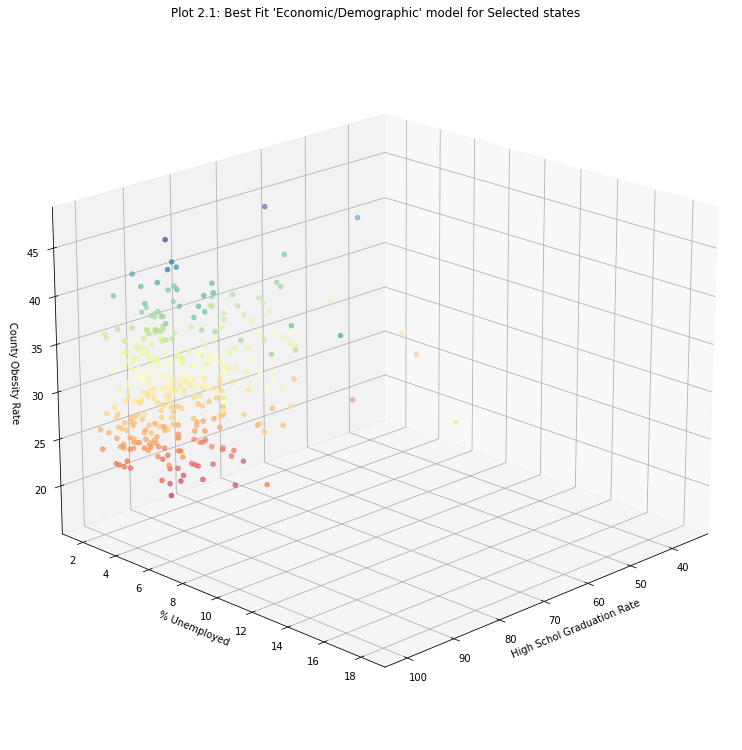

In [27]:

fig = plt.figure(1, figsize=(10, 10))
axes = Axes3D(fig, elev=20, azim=45)
axes.scatter(sample_df["High School Graduation Rate"], sample_df["% Unemployed"], sample_df['% Adults with Obesity'], c=sample_df['% Adults with Obesity'], cmap=plt.cm.get_cmap("Spectral"))
plt.title("Plot 2.1: Best Fit 'Economic/Demographic' model for Selected states")
axes.set_xlabel("High Schol Graduation Rate")
axes.set_ylabel("% Unemployed")
axes.set_zlabel("County Obesity Rate")
print("Equation: y = {:.2f} + {:.2f}x1 + {:.2f}x2".format(regr.intercept_, regr.coef_[0],
                                                         regr.coef_[1]))
plt.savefig("output_diagrams/Plot 2-1.png")
plt.show()

### Health Factors Models

### Model 1: All health factor predictors

In [28]:
X = sample_df[['% With Access to Exercise Opportunities', '% Physically Inactive' , 'Primary Care Physicians Rate']].astype(float)
Y = sample_df['% Adults with Obesity'].astype(float)
X.head()

,% With Access to Exercise Opportunities,% Physically Inactive,Primary Care Physicians Rate
1357,100.0,15.0,110.0
1358,76.0,25.0,67.0
1359,84.0,22.0,61.0
1360,60.0,31.0,44.0
1361,75.0,28.0,32.0


In [29]:
regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Intercept: 
 16.865160212797182
Coefficients: 
 [ 0.01210807  0.53872704 -0.03122865]


In [30]:
X = sm.add_constant(X) 
 
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
predictions.head()

1357    22.721721
1358    29.161230
1359    27.829285
1360    32.918122
1361    31.858306
dtype: float64

In [31]:
print_model = model.summary()
print(print_model)

                              OLS Regression Results                             
Dep. Variable:     % Adults with Obesity   R-squared:                       0.378
Model:                               OLS   Adj. R-squared:                  0.373
Method:                    Least Squares   F-statistic:                     71.02
Date:                   Sun, 29 Nov 2020   Prob (F-statistic):           6.78e-36
Time:                           22:30:42   Log-Likelihood:                -1025.9
No. Observations:                    354   AIC:                             2060.
Df Residuals:                        350   BIC:                             2075.
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

In [32]:

# The all-health factors model has a respectable multiple R of 0.378 and explains 37.8 percent of the variability in obesity rates in the current dataset. 
# In addition, this model reports a good F-ratio of 71.02 which would almost certainly be statistically sgnificant and not  a product of chance. As for the predictors, access to exercise oppurtunities, while it has a substantial contribution to the model, does not appear to be statistically significant. 
# It appears that Physical inactivity is the best predictor from this model.

### BestFit Models

### The following best fit models test the best predictors from the previous models in various combinations in order to build a model that best predicts obesity rates across all US counties.

### Best Fit model 1: Median Income and Rate of Inactivity

In [33]:
X = sample_df[['Median Income','% Physically Inactive']].astype(float)
Y = sample_df['% Adults with Obesity'].astype(float)
X.head()

,Median Income,% Physically Inactive
1357,92574.0,15.0
1358,61198.0,25.0
1359,48443.0,22.0
1360,58151.0,31.0
1361,56704.0,28.0


In [34]:
regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Intercept: 
 18.144227123745708
Coefficients: 
 [-3.73077877e-05  5.38647337e-01]


In [35]:

X = sm.add_constant(X) 
 
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
predictions.head()

1357    22.770206
1358    29.327249
1359    28.187167
1360    32.672809
1361    31.110852
dtype: float64

In [36]:
print_model = model.summary()
print(print_model)

                              OLS Regression Results                             
Dep. Variable:     % Adults with Obesity   R-squared:                       0.368
Model:                               OLS   Adj. R-squared:                  0.364
Method:                    Least Squares   F-statistic:                     102.1
Date:                   Sun, 29 Nov 2020   Prob (F-statistic):           1.14e-35
Time:                           22:30:45   Log-Likelihood:                -1028.9
No. Observations:                    354   AIC:                             2064.
Df Residuals:                        351   BIC:                             2075.
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------


Equation: y = 18.14 + -0.00x1 + 0.54x2


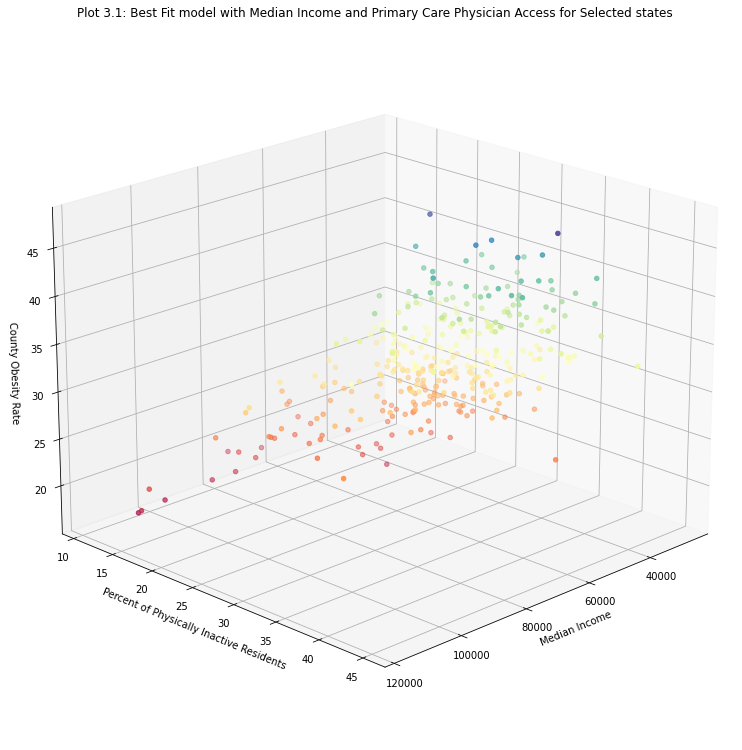

In [37]:
fig = plt.figure(1, figsize=(10, 10))
axes = Axes3D(fig, elev=20, azim=45)
axes.scatter(sample_df["Median Income"], sample_df["% Physically Inactive"], sample_df['% Adults with Obesity'], c=sample_df['% Adults with Obesity'], cmap=plt.cm.get_cmap("Spectral"))
plt.title("Plot 3.1: Best Fit model with Median Income and Primary Care Physician Access for Selected states")
axes.set_xlabel("Median Income")
axes.set_ylabel("Percent of Physically Inactive Residents")
axes.set_zlabel("County Obesity Rate")
print("Equation: y = {:.2f} + {:.2f}x1 + {:.2f}x2".format(regr.intercept_, regr.coef_[0], regr.coef_[1]))
plt.savefig("output_diagrams/Plot 3-1.png")                                                       
plt.show()

### Best Fit model 2: High School Graduation Rate and Access to Primary Care Physicians

In [38]:

X = sample_df[['Primary Care Physicians Rate','High School Graduation Rate']].astype(float)
Y = sample_df['% Adults with Obesity'].astype(float)
X.head()

,Primary Care Physicians Rate,High School Graduation Rate
1357,110.0,87.0
1358,67.0,88.0
1359,61.0,85.0
1360,44.0,90.0
1361,32.0,89.0


In [39]:
regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Intercept: 
 36.877158746888725
Coefficients: 
 [-0.06993994 -0.03134912]


In [40]:
X = sm.add_constant(X) 
 
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
predictions.head()

1357    26.456391
1358    29.432460
1359    29.946147
1360    30.978380
1361    31.849009
dtype: float64

In [41]:
print_model = model.summary()
print(print_model)

                              OLS Regression Results                             
Dep. Variable:     % Adults with Obesity   R-squared:                       0.126
Model:                               OLS   Adj. R-squared:                  0.121
Method:                    Least Squares   F-statistic:                     25.31
Date:                   Sun, 29 Nov 2020   Prob (F-statistic):           5.38e-11
Time:                           22:30:48   Log-Likelihood:                -1086.2
No. Observations:                    354   AIC:                             2178.
Df Residuals:                        351   BIC:                             2190.
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

Equation: y = 36.88 + -0.07x1 + -0.03x2


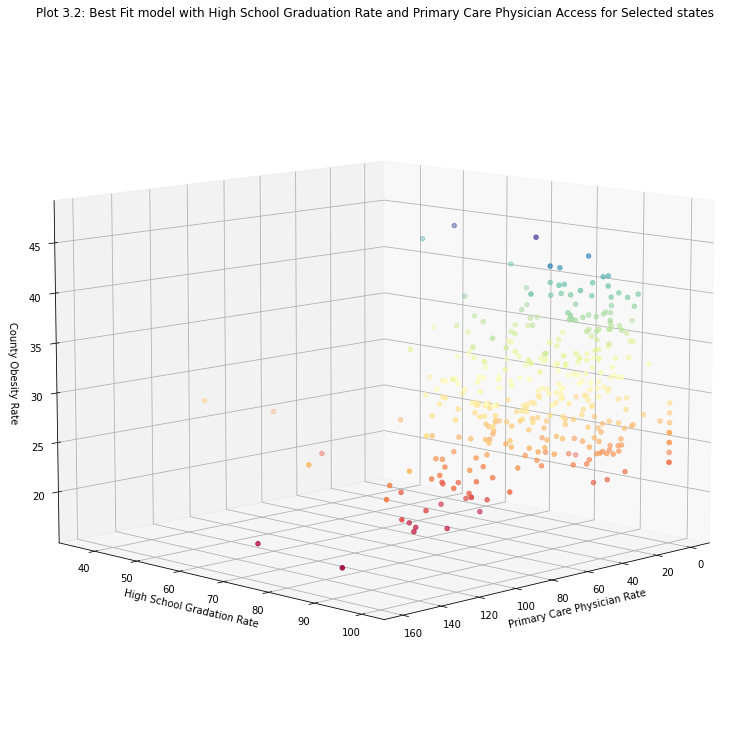

In [42]:
fig = plt.figure(1, figsize=(10, 10))
axes = Axes3D(fig, elev=10, azim=45)
axes.scatter(sample_df["Primary Care Physicians Rate"], sample_df["High School Graduation Rate"], sample_df['% Adults with Obesity'], c=sample_df['% Adults with Obesity'], cmap=plt.cm.get_cmap("Spectral"))
plt.title("Plot 3.2: Best Fit model with High School Graduation Rate and Primary Care Physician Access for Selected states")
axes.set_xlabel("Primary Care Physician Rate")
axes.set_ylabel("High School Gradation Rate")
axes.set_zlabel("County Obesity Rate")
print("Equation: y = {:.2f} + {:.2f}x1 + {:.2f}x2".format(regr.intercept_, regr.coef_[0],
                                                         regr.coef_[1]))
plt.savefig("output_diagrams/Plot 3-2.png")
plt.show()

### Best fit Model 3: Physical Inactivity and Unemployment

In [43]:
X = sample_df[['% Physically Inactive','% Unemployed']].astype(float)
Y = sample_df['% Adults with Obesity'].astype(float)
X.head()

,% Physically Inactive,% Unemployed
1357,15.0,3.0
1358,25.0,4.0
1359,22.0,5.0
1360,31.0,4.0
1361,28.0,12.9


In [44]:
regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Intercept: 
 12.726300649964742
Coefficients: 
 [0.56245354 0.68160963]


In [45]:
X = sm.add_constant(X) 
 
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
predictions.head()

1357    23.207933
1358    29.514078
1359    28.508327
1360    32.888799
1361    37.267764
dtype: float64

In [46]:
print_model = model.summary()
print(print_model)

                              OLS Regression Results                             
Dep. Variable:     % Adults with Obesity   R-squared:                       0.398
Model:                               OLS   Adj. R-squared:                  0.395
Method:                    Least Squares   F-statistic:                     116.1
Date:                   Sun, 29 Nov 2020   Prob (F-statistic):           2.00e-39
Time:                           22:30:51   Log-Likelihood:                -1020.2
No. Observations:                    354   AIC:                             2046.
Df Residuals:                        351   BIC:                             2058.
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------


Equation: y = 12.73 + 0.56x1 + 0.68x2


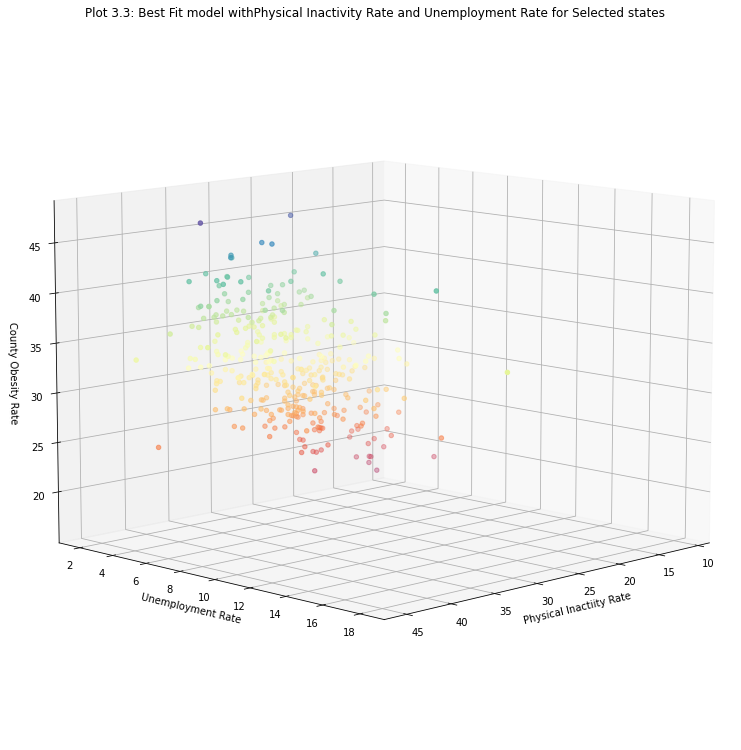

In [47]:
fig = plt.figure(1, figsize=(10, 10))
axes = Axes3D(fig, elev=10, azim=45)
axes.scatter(sample_df['% Physically Inactive'], sample_df['% Unemployed'], sample_df['% Adults with Obesity'], c=sample_df['% Adults with Obesity'], cmap=plt.cm.get_cmap("Spectral"))
plt.title("Plot 3.3: Best Fit model withPhysical Inactivity Rate and Unemployment Rate for Selected states")
axes.set_xlabel("Physical Inactiity Rate")
axes.set_ylabel("Unemployment Rate")
axes.set_zlabel("County Obesity Rate")
print("Equation: y = {:.2f} + {:.2f}x1 + {:.2f}x2".format(regr.intercept_, regr.coef_[0],
                                                         regr.coef_[1]))
plt.savefig("output_diagrams/Plot 3-3.png")
plt.show()

### Complex Models

### More Complex models of 3 or more predictors will be tested for best fit on a sample of selected states.
### Model 1: 3 predictors: physical inactivity, education, unemployment

In [48]:
X = sample_df[[ '% Physically Inactive' ,'High School Graduation Rate','% Unemployed']].astype(float)
Y = sample_df['% Adults with Obesity'].astype(float)
X.head()

,% Physically Inactive,High School Graduation Rate,% Unemployed
1357,15.0,87.0,3.0
1358,25.0,88.0,4.0
1359,22.0,85.0,5.0
1360,31.0,90.0,4.0
1361,28.0,89.0,12.9


In [49]:
regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Intercept: 
 11.189828802214443
Coefficients: 
 [0.5612275  0.01698287 0.6939207 ]


In [50]:
X = sm.add_constant(X) 
 
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
predictions.head()

1357    23.167513
1358    29.490692
1359    28.449981
1360    32.892022
1361    37.367251
dtype: float64

In [51]:
print_model = model.summary()
print(print_model)

                              OLS Regression Results                             
Dep. Variable:     % Adults with Obesity   R-squared:                       0.399
Model:                               OLS   Adj. R-squared:                  0.394
Method:                    Least Squares   F-statistic:                     77.42
Date:                   Sun, 29 Nov 2020   Prob (F-statistic):           1.96e-38
Time:                           22:30:54   Log-Likelihood:                -1020.0
No. Observations:                    354   AIC:                             2048.
Df Residuals:                        350   BIC:                             2063.
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

In [52]:
X = sample_df[['% Physically Inactive' ,  'Median Income', '% Unemployed']].astype(float)
Y = sample_df['% Adults with Obesity'].astype(float)
X.head()

,% Physically Inactive,Median Income,% Unemployed
1357,15.0,92574.0,3.0
1358,25.0,61198.0,4.0
1359,22.0,48443.0,5.0
1360,31.0,58151.0,4.0
1361,28.0,56704.0,12.9


In [53]:
regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Intercept: 
 13.852481570078016
Coefficients: 
 [ 5.49135434e-01 -1.21893312e-05  6.53340277e-01]


In [54]:
X = sm.add_constant(X) 
 
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
predictions.head()

1357    22.921119
1358    29.448266
1359    28.609675
1360    32.780219
1361    36.965179
dtype: float64

In [55]:
print_model = model.summary()
print(print_model)

                              OLS Regression Results                             
Dep. Variable:     % Adults with Obesity   R-squared:                       0.399
Model:                               OLS   Adj. R-squared:                  0.394
Method:                    Least Squares   F-statistic:                     77.39
Date:                   Sun, 29 Nov 2020   Prob (F-statistic):           2.02e-38
Time:                           22:30:56   Log-Likelihood:                -1020.0
No. Observations:                    354   AIC:                             2048.
Df Residuals:                        350   BIC:                             2063.
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------


In [56]:
X = sample_df[['% With Access to Exercise Opportunities', '% Physically Inactive' ,'High School Graduation Rate', '% Unemployed']].astype(float)
Y = sample_df['% Adults with Obesity'].astype(float)
X.head()

,% With Access to Exercise Opportunities,% Physically Inactive,High School Graduation Rate,% Unemployed
1357,100.0,15.0,87.0,3.0
1358,76.0,25.0,88.0,4.0
1359,84.0,22.0,85.0,5.0
1360,60.0,31.0,90.0,4.0
1361,75.0,28.0,89.0,12.9


In [57]:
regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Intercept: 
 12.204673126438504
Coefficients: 
 [-0.0064556   0.55159457  0.0131997   0.69348334]


In [58]:
X = sm.add_constant(X) 
 
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
predictions.head()

1357    23.061856
1358    29.439419
1359    28.386875
1360    32.878676
1361    37.285860
dtype: float64

In [59]:
print_model = model.summary()
print(print_model)

                              OLS Regression Results                             
Dep. Variable:     % Adults with Obesity   R-squared:                       0.400
Model:                               OLS   Adj. R-squared:                  0.393
Method:                    Least Squares   F-statistic:                     58.05
Date:                   Sun, 29 Nov 2020   Prob (F-statistic):           1.58e-37
Time:                           22:30:58   Log-Likelihood:                -1019.8
No. Observations:                    354   AIC:                             2050.
Df Residuals:                        349   BIC:                             2069.
Df Model:                              4                                         
Covariance Type:               nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

### Applying the best model to the full dataset

In [60]:
X = omni_df[[ '% Physically Inactive' ,'High School Graduation Rate','% Unemployed']].astype(float)
Y = omni_df['% Adults with Obesity'].astype(float)
X.head()

,% Physically Inactive,High School Graduation Rate,% Unemployed
0,23.0,88.0,2.5
1,22.0,94.0,2.5
2,19.0,89.0,2.5
3,26.0,92.0,3.2
4,19.0,95.0,2.1


In [61]:
regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Intercept: 
 18.01864776885874
Coefficients: 
 [ 0.51412861 -0.01129265  0.44094131]


In [62]:
X = sm.add_constant(X) 
 
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
predictions.head()

0    29.952206
1    29.370321
2    27.884399
3    31.758080
4    27.640266
dtype: float64

In [63]:
print_model = model.summary()
print(print_model)

                              OLS Regression Results                             
Dep. Variable:     % Adults with Obesity   R-squared:                       0.342
Model:                               OLS   Adj. R-squared:                  0.341
Method:                    Least Squares   F-statistic:                     503.9
Date:                   Sun, 29 Nov 2020   Prob (F-statistic):          1.05e-263
Time:                           22:31:00   Log-Likelihood:                -8451.7
No. Observations:                   2914   AIC:                         1.691e+04
Df Residuals:                       2910   BIC:                         1.694e+04
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

In [64]:
X = omni_df[['% With Access to Exercise Opportunities', '% Physically Inactive' ,'High School Graduation Rate',  'Median Income', 'Primary Care Physicians Rate', '% Unemployed']].astype(float)
Y = omni_df['% Adults with Obesity'].astype(float)
X.head()

,% With Access to Exercise Opportunities,% Physically Inactive,High School Graduation Rate,Median Income,Primary Care Physicians Rate,% Unemployed
0,87.0,23.0,88.0,68368.0,64.0,2.5
1,81.0,22.0,94.0,61116.0,92.0,2.5
2,75.0,19.0,89.0,63057.0,68.0,2.5
3,74.0,26.0,92.0,45696.0,114.0,3.2
4,90.0,19.0,95.0,63153.0,197.0,2.1


In [65]:
regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Intercept: 
 24.398582222106004
Coefficients: 
 [-9.74494479e-03  4.28506176e-01 -1.53736784e-02 -3.62243783e-05
 -1.25249378e-02  3.23740021e-01]


In [66]:
X = sm.add_constant(X) 
 
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
predictions.head()

0    29.584696
1    29.034418
2    28.114525
3    31.357054
4    26.127418
dtype: float64

In [67]:
print_model = model.summary()
print(print_model)

                              OLS Regression Results                             
Dep. Variable:     % Adults with Obesity   R-squared:                       0.358
Model:                               OLS   Adj. R-squared:                  0.357
Method:                    Least Squares   F-statistic:                     270.2
Date:                   Sun, 29 Nov 2020   Prob (F-statistic):          2.52e-275
Time:                           22:31:02   Log-Likelihood:                -8415.6
No. Observations:                   2914   AIC:                         1.685e+04
Df Residuals:                       2907   BIC:                         1.689e+04
Df Model:                              6                                         
Covariance Type:               nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------